In [4]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [2]:
m = pd.read_csv('/home/shared/splus_gaia/data/h-alpha-selection-marina/MC/halpha_emitters_mc.csv')

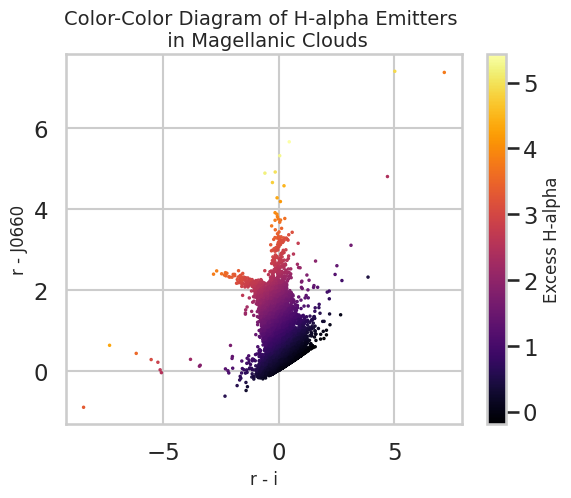

<Figure size 640x480 with 0 Axes>

In [79]:
#quero plotar ri e rj660 e colorir por excess
plt.scatter(m['ri'], m['rJ0660'], c=m['excess'], cmap='inferno', s=1)
#legenda da cor
cbar = plt.colorbar()
cbar.set_label('Excess H-alpha', fontsize=12)
plt.xlabel('r - i', fontsize = 12)
plt.ylabel('r - J0660', fontsize = 12)
plt.title('Color-Color Diagram of H-alpha Emitters \n in Magellanic Clouds', fontsize=14)
plt.show()
plt.tight_layout()

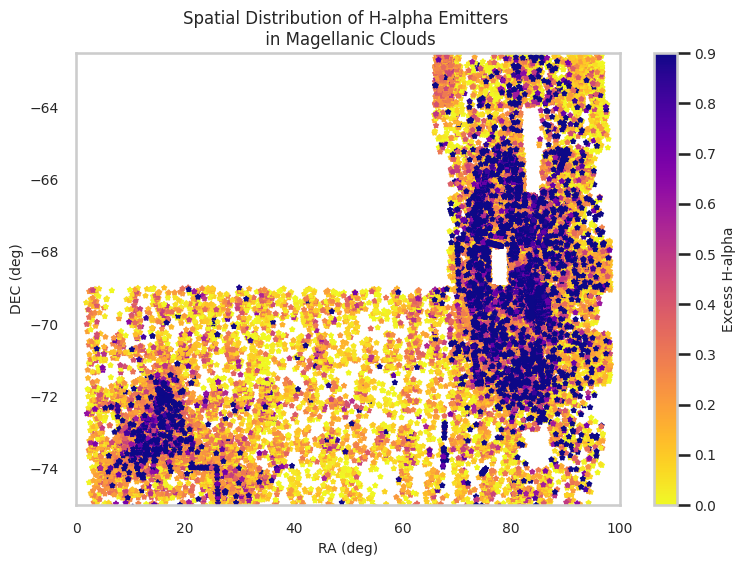

In [94]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Defina os limites da escala de cor
vmin = 0.0
vmax = 0.9

# Normalize para esse intervalo
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma_r

plt.figure(figsize=(8,6))
sc = plt.scatter(
    m['ra'],
    m['dec'],
    c=m['excess'],
    cmap=cmap,
    norm=norm,
    s=10, 
    marker = '*'

)

# Barra de cores
cbar = plt.colorbar(sc)

cbar.set_label('Excess H-alpha', fontsize=10)
cbar.ax.tick_params(labelsize=10)
# Eixos e título
plt.xlabel('RA (deg)', fontsize=10)
plt.ylabel('DEC (deg)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Spatial Distribution of H-alpha Emitters \n in Magellanic Clouds', fontsize=12)

# Limites da região
plt.xlim(0, 100)
plt.ylim(-75, -62.5)

plt.tight_layout()
plt.grid()
plt.show()

In [5]:
m['excess'] = (m["mag_psf_r"] + m["mag_psf_i"]) / 2 - m["mag_psf_j0660"]
m_ex = m[m['excess'] >=  0.2]

In [13]:
simbad = pd.read_csv('/home/shared/splus_gaia/data/h-alpha-selection-marina/MC/halpha_emitters_mc_simbad.csv')

In [4]:
bica = pd.read_csv('/home/marina/FullCatalogBica_08_20.csv')

In [5]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord, search_around_sky, Angle
import astropy.units as u

def match_emitters_to_clusters(
    clusters: pd.DataFrame,
    stars: pd.DataFrame,
    *,
    cluster_ra_col: str = "ra",        # RA dos aglomerados (graus)
    cluster_dec_col: str = "dec",      # Dec dos aglomerados (graus)
    cluster_amaj_col: str = "amaj",    # semi-eixo maior (ex.: arcmin) — tratado como raio circular
    stars_ra_col: str = "ra",          # RA das estrelas (graus)
    stars_dec_col: str = "dec",        # Dec das estrelas (graus)
    amaj_unit: str = "arcmin",         # unidade do amaj (ex.: "arcmin", "arcsec", "deg")
    keep_cols_clusters: list | None = None,  # colunas extras do df de aglomerados para levar ao resultado
    keep_cols_stars: list | None = None,     # colunas extras do df de estrelas para levar ao resultado
) -> pd.DataFrame:
    """
    Associa estrelas Hα a aglomerados retornando apenas as que estão dentro do amaj de cada aglomerado.

    Parameters
    ----------
    clusters : pandas.DataFrame
        Tabela de aglomerados com colunas de posição e amaj.
    stars : pandas.DataFrame
        Tabela de estrelas emissoras com colunas de posição.
    cluster_ra_col : str, default "ra"
        Nome da coluna de RA dos aglomerados (em graus).
    cluster_dec_col : str, default "dec"
        Nome da coluna de Dec dos aglomerados (em graus).
    cluster_amaj_col : str, default "amaj"
        Nome da coluna do semi-eixo maior do aglomerado.
        **É interpretado como um raio circular** para a seleção.
    stars_ra_col : str, default "ra"
        Nome da coluna de RA das estrelas (em graus).
    stars_dec_col : str, default "dec"
        Nome da coluna de Dec das estrelas (em graus).
    amaj_unit : str, default "arcmin"
        Unidade de `amaj` (por exemplo: "arcmin", "arcsec" ou "deg").
    keep_cols_clusters : list[str] | None
        Colunas adicionais do DataFrame de aglomerados a incluir no resultado.
    keep_cols_stars : list[str] | None
        Colunas adicionais do DataFrame de estrelas a incluir no resultado.

    Returns
    -------
    pandas.DataFrame
        Uma tabela já mesclada contendo:
        - índices originais (`cluster_index`, `star_index`)
        - separação angular (`sep_arcsec`, `sep_arcmin`)
        - colunas dos aglomerados com prefixo `cluster_`
        - colunas das estrelas com prefixo `star_`

    Notes
    -----
    * `amaj` é tratado como **semi-eixo maior** em unidade dada por `amaj_unit` e
      usado como **raio circular equivalente** para o corte (i.e., sep <= amaj).
    * A rotina usa um raio máximo global (= max(amaj)) em `search_around_sky`
      e depois filtra par-a-par por `amaj` específico de cada aglomerado.
    * Linhas com posições/raios inválidos (NaN, não positivos) são ignoradas.
    """
    # Escolha das colunas para carregar/propagar
    if keep_cols_clusters is None:
        keep_cols_clusters = []
    if keep_cols_stars is None:
        keep_cols_stars = []

    # Filtrar entradas válidas nos aglomerados
    cl_req = [cluster_ra_col, cluster_dec_col, cluster_amaj_col] + keep_cols_clusters
    cl_df = clusters[cl_req].copy()
    cl_df = cl_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[cluster_ra_col, cluster_dec_col, cluster_amaj_col])
    # descarta amaj <= 0
    cl_df = cl_df[cl_df[cluster_amaj_col] > 0].copy()

    # Filtrar entradas válidas nas estrelas
    st_req = [stars_ra_col, stars_dec_col] + keep_cols_stars
    st_df = stars[st_req].copy()
    st_df = st_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[stars_ra_col, stars_dec_col])

    if cl_df.empty or st_df.empty:
        return pd.DataFrame(columns=[
            "cluster_index","star_index","sep_arcsec","sep_arcmin"
        ])

    # Coordenadas
    c_clusters = SkyCoord(ra=cl_df[cluster_ra_col].to_numpy() * u.deg,
                          dec=cl_df[cluster_dec_col].to_numpy() * u.deg)
    c_stars = SkyCoord(ra=st_df[stars_ra_col].to_numpy() * u.deg,
                       dec=st_df[stars_dec_col].to_numpy() * u.deg)

    # Raio máximo global para a busca
    unit = u.Unit(amaj_unit)
    max_amaj = np.nanmax(cl_df[cluster_amaj_col].to_numpy())
    seplimit = Angle(max_amaj, unit)

    # Busca inicial (eficiente)
    idx_cl, idx_st, sep2d, _ = search_around_sky(c_clusters, c_stars, seplimit=seplimit)

    if len(idx_cl) == 0:
        return pd.DataFrame(columns=[
            "cluster_index","star_index","sep_arcsec","sep_arcmin"
        ])

    # Limite específico por aglomerado (par-a-par)
    amaj_per_pair = Angle(cl_df.iloc[idx_cl][cluster_amaj_col].to_numpy(), unit)
    keep = sep2d <= amaj_per_pair

    if not np.any(keep):
        return pd.DataFrame(columns=[
            "cluster_index","star_index","sep_arcsec","sep_arcmin"
        ])

    # Construir resultado
    pairs = pd.DataFrame({
        "cluster_index": cl_df.index.values[idx_cl[keep]],
        "star_index": st_df.index.values[idx_st[keep]],
        "sep_arcsec": sep2d[keep].arcsec,
        "sep_arcmin": sep2d[keep].to(u.arcmin).value,
    })

    # Anexar metadados dos aglomerados e estrelas (com prefixos)
    cl_out = clusters.loc[pairs["cluster_index"]][[cluster_ra_col, cluster_dec_col, cluster_amaj_col] + keep_cols_clusters]
    cl_out = cl_out.add_prefix("cluster_").reset_index(drop=True)

    st_out = stars.loc[pairs["star_index"]][[stars_ra_col, stars_dec_col] + keep_cols_stars]
    st_out = st_out.add_prefix("star_").reset_index(drop=True)

    result = pd.concat([pairs.reset_index(drop=True), cl_out, st_out], axis=1)

    # Ordenar por separação (útil)
    result = result.sort_values("sep_arcmin", ascending=True).reset_index(drop=True)
    return result

In [6]:
# clusters_df: colunas ["name","ra","dec","amaj"] (amaj em arcmin, por ex.)
# emitters_df: colunas ["source_id","ra","dec", ...]
out = match_emitters_to_clusters(
    bica,
    m,
    cluster_ra_col="ra_deg",
    cluster_dec_col="dec_deg",
    cluster_amaj_col="amaj",
    stars_ra_col="ra",
    stars_dec_col="dec",
    amaj_unit="arcmin",
    keep_cols_clusters=["Names"],         # traga o nome do aglomerado
    keep_cols_stars=["id","excess", "err_mag_psf_u", "err_mag_psf_j0378", "err_mag_psf_j0395",
       "err_mag_psf_j0410", "err_mag_psf_j0430", "err_mag_psf_g",
       "err_mag_psf_j0515", "err_mag_psf_r", "err_mag_psf_j0660",
       "err_mag_psf_i", "err_mag_psf_j0861", "err_mag_psf_z", "mag_psf_u",
       "mag_psf_j0378", "mag_psf_j0395", "mag_psf_j0410", "mag_psf_j0430",
       "mag_psf_g", "mag_psf_j0515", "mag_psf_r", "mag_psf_j0660", "mag_psf_i",
       "mag_psf_j0861", "mag_psf_z"]  # traga id/atributos da estrela
)

# "out" tem uma linha por estrela-associada, com "cluster_*" e "star_*"

In [7]:
out

,cluster_index,star_index,sep_arcsec,sep_arcmin,cluster_ra_deg,cluster_dec_deg,cluster_amaj,cluster_Names,star_ra,star_dec,...,star_mag_psf_j0395,star_mag_psf_j0410,star_mag_psf_j0430,star_mag_psf_g,star_mag_psf_j0515,star_mag_psf_r,star_mag_psf_j0660,star_mag_psf_i,star_mag_psf_j0861,star_mag_psf_z
0,4791,27932,0.039388,0.000656,15.254583,-71.595556,0.30,MA1236,15.254615,-71.595560,...,16.975983,16.968710,17.010700,17.076510,17.154974,17.378143,17.180742,17.700773,17.896646,17.911684
1,3795,5660,0.183877,0.003065,12.133750,-72.761667,0.50,H86-101,12.133603,-72.761640,...,17.275818,17.319616,17.324839,17.487246,17.501074,17.583817,17.453552,17.788280,18.015783,17.940504
2,4851,30147,0.220588,0.003676,15.508750,-72.233611,0.79,BMS380,15.508577,-72.233580,...,16.749110,16.767378,16.839777,16.954199,16.959543,17.172480,17.056507,17.426151,17.557346,17.547558
3,3392,10084,0.281611,0.004694,10.413750,-73.385556,1.57,BIS302,10.413962,-73.385605,...,17.250578,17.288755,17.318714,17.432713,17.474980,17.613832,17.542665,17.796530,17.975710,17.994476
4,4824,18296,0.316100,0.005268,15.382917,-71.845000,0.70,"SMC-N72,B106,MA1271/MA1274",15.382846,-71.845085,...,15.094668,15.199860,15.258618,15.438092,15.464859,15.694858,15.512912,16.091377,16.260895,16.295807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30289,5736,23634,7166.851852,119.447531,32.045833,-74.446111,120.00,"BS I,Bica-Schmitt I",28.820267,-72.676200,...,17.262962,16.632736,16.570543,16.086231,15.926118,15.439963,15.313627,15.257951,15.111448,15.161289
30290,5736,44935,7167.639687,119.460661,32.045833,-74.446111,120.00,"BS I,Bica-Schmitt I",24.610338,-74.668710,...,19.064184,18.614532,18.590887,18.384180,18.233480,18.028656,17.848630,17.958683,17.865513,17.952934
30291,5736,19322,7170.852849,119.514214,32.045833,-74.446111,120.00,"BS I,Bica-Schmitt I",25.458641,-73.616070,...,17.450663,17.416380,17.501831,17.597002,17.618940,17.801926,17.721510,18.059685,18.162312,18.225597
30292,5736,695,7185.245890,119.754098,32.045833,-74.446111,120.00,"BS I,Bica-Schmitt I",39.500270,-74.476160,...,14.333851,13.725114,13.623662,13.208361,13.017140,12.726866,12.662266,12.619847,12.521900,12.547705


In [8]:
names = out.groupby('cluster_Names').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [9]:
names

,cluster_Names,counts
669,"BS I,Bica-Schmitt I",1045
1184,DEMS124,904
1179,DEMS114,705
1172,DEMS104,660
710,BS153,499
...,...,...
531,BMS302,1
532,BMS308,1
286,"BIS552,BUS819",1
1759,KMHK270,1


In [10]:
b3 = out[out['cluster_Names'] == 'B3                                     ']
b3

,cluster_index,star_index,sep_arcsec,sep_arcmin,cluster_ra_deg,cluster_dec_deg,cluster_amaj,cluster_Names,star_ra,star_dec,...,star_mag_psf_j0395,star_mag_psf_j0410,star_mag_psf_j0430,star_mag_psf_g,star_mag_psf_j0515,star_mag_psf_r,star_mag_psf_j0660,star_mag_psf_i,star_mag_psf_j0861,star_mag_psf_z
54,3121,1036,1.225353,0.020423,5.99375,-73.634167,1.2,B3,5.994515,-73.63443,...,17.218578,17.351942,17.140650,16.667686,17.582430,16.466170,14.371491,17.232632,17.485434,17.369330
265,3121,47313,3.494860,0.058248,5.99375,-73.634167,1.2,B3,5.991413,-73.63488,...,NaN,20.569744,20.378815,20.185932,20.716143,19.851645,18.913670,19.795662,19.774273,19.657394
460,3121,34943,4.996816,0.083280,5.99375,-73.634167,1.2,B3,5.998389,-73.63370,...,20.655647,19.787180,19.944893,19.548662,19.441600,18.964481,18.611696,18.746390,18.711779,18.634024


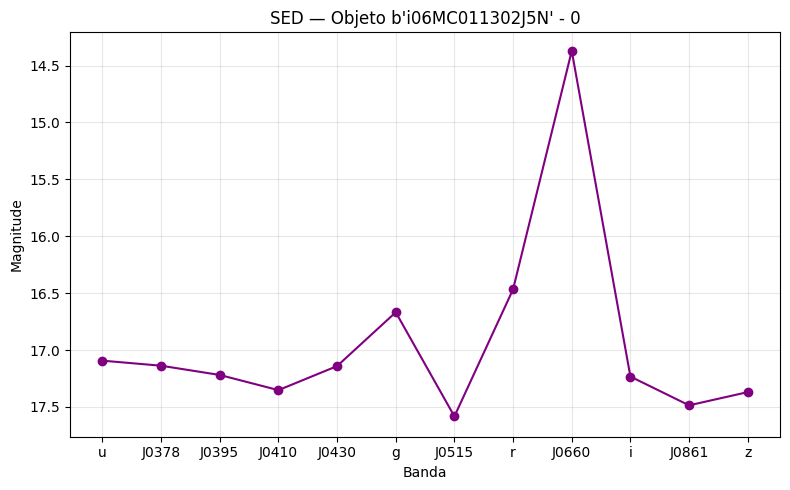

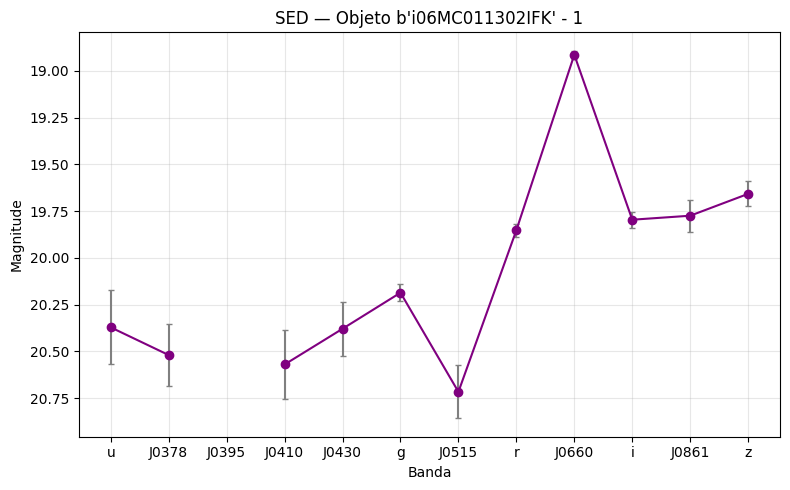

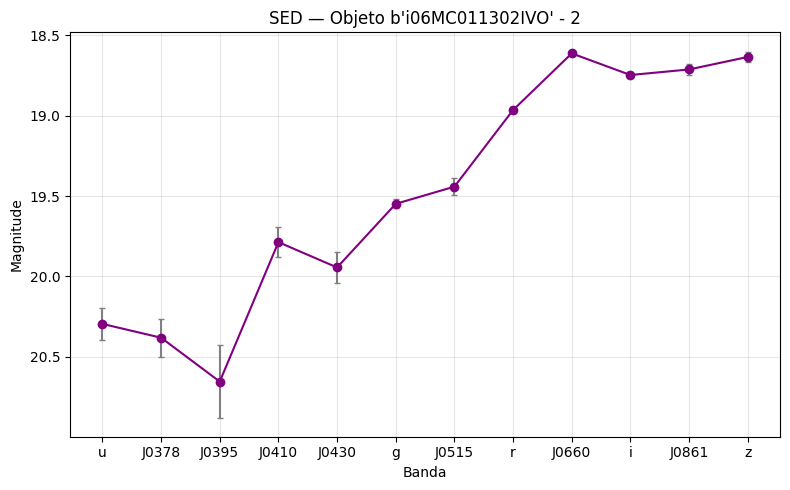

In [34]:
import numpy as np
import matplotlib.pyplot as plt

bands = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
wavelengths = np.array([3536, 3770, 3940, 4094, 4292, 4751, 5133, 6258, 6614, 7690, 8611, 8831])

mag_cols = [f"star_mag_psf_{b.lower()}" for b in bands]
err_cols = [f"star_err_mag_psf_{b.lower()}" for b in bands]
has_errors = all(col in b3.columns for col in err_cols)

i = 0
for idx, row in b3.iterrows():
    mags = row[mag_cols].to_numpy()

    plt.figure(figsize=(8, 5))
    if has_errors:
        errs = row[err_cols].to_numpy()
        plt.errorbar(bands, mags, yerr=errs, fmt='o-', color='purple', ecolor='gray', capsize=2)
    else:
        plt.plot(bands, mags, 'o-', color='purple')

    plt.gca().invert_yaxis()
    plt.xlabel('Banda')
    plt.ylabel('Magnitude')
    plt.title(f'SED — Objeto {row["star_id"]} - {i}')  # <<< usar a linha atual
    # plt.title(f'SED — Objeto {row['id']} - {row['main_type']}')  # se quiser incluir o tipo

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    i += 1
    if i >= 50:
        break

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
import splusdata

# ---------------- Config ----------------
bands = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
mag_cols = [f"star_mag_psf_{b.lower()}" for b in bands]
err_cols = [f"star_err_mag_psf_{b.lower()}" for b in bands]
MAX_STARS = 30

def get_splus_client():
    return splusdata.Core('marinaiza', 'Mari1407*')

def load_single_band_fits(client, ra, dec, size_arcsec=120, band="r", data_release="idr6"):
    hdu = client.stamp(
        ra=float(ra), dec=float(dec),
        size=size_arcsec, size_unit="arcsec",
        band=band, data_release=data_release
    )
    img = hdu[1].data
    wcs = WCS(hdu[1].header)
    return img, wcs

def pick_colors(n):
    cmap = plt.get_cmap("tab20")
    return [cmap(i % 20) for i in range(n)]

def plot_cluster_image_and_seds(
    b3,
    center_ra, center_dec,
    size_arcsec=120,
    ra_col="ra", dec_col="dec",
    id_col="star_id",
    data_release="idr6",
    image_band="r",
    limit=MAX_STARS,
    # --- NEW aperture options ---
    aperture_col=None,              # e.g. "aper_r_arcsec" (per-star)
    aperture_unit="arcsec",         # "arcsec" or "pix"
    aperture_is_diameter=False,     # set True if values are diameter, not radius
    aperture_alpha=0.9,
    aperture_lw=1.2,
    draw_center_dot=True
):
    """
    Left: Single-band FITS image with star overlay (+ per-star aperture circle).
    Right: SEDs of selected stars.

    aperture_col:
        Column in `b3` holding aperture size per star.
    aperture_unit:
        "arcsec" (will be converted using WCS) or "pix" (used directly).
    aperture_is_diameter:
        If True, values in aperture_col are diameter; we divide by 2.
    """
    # Select stars with finite magnitudes
    valid = b3[mag_cols].applymap(np.isfinite).all(axis=1)
    stars = b3[valid].copy().head(limit).reset_index(drop=True)
    if len(stars) == 0:
        raise ValueError("No stars with valid magnitudes")

    colors = pick_colors(len(stars))
    client = get_splus_client()
    img, wcs = load_single_band_fits(client, center_ra, center_dec, size_arcsec, image_band, data_release)

    # Pixel scale (arcsec/pixel) from WCS
    # proj_plane_pixel_scales returns deg/pix; convert to arcsec/pix
    pix_scales_deg = proj_plane_pixel_scales(wcs)   # (dy, dx) in deg/pix
    arcsec_per_pix_y, arcsec_per_pix_x = pix_scales_deg * 3600.0
    # Use mean scale for circular apertures (OK for small rotations)
    arcsec_per_pix = float((arcsec_per_pix_x + arcsec_per_pix_y) / 2.0)

    # ---------- Figure ----------
    fig = plt.figure(figsize=(13, 6), dpi=120)
    gs = GridSpec(nrows=1, ncols=2, figure=fig, width_ratios=[1.2, 1.0], wspace=0.2)

    # ---------- Left: FITS image + stars ----------
    vmin = np.percentile(img, 1)
    vmax = np.percentile(img, 99)
    ax_img = fig.add_subplot(gs[0, 0], projection=wcs)
    ax_img.imshow(img, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)
    ax_img.set_xlabel("RA")
    ax_img.set_ylabel("Dec")
    ax_img.grid(alpha=0.2, color="white", ls=":")

    # Plot stars + apertures
    for i, row in stars.iterrows():
        ra = float(row[ra_col]); dec = float(row[dec_col])

        # Center marker (world coords)
        if draw_center_dot:
            ax_img.scatter(
                ra * u.deg, dec * u.deg,
                transform=ax_img.get_transform('world'),
                s=30, facecolors='none', edgecolors=colors[i], linewidths=1.5, zorder=3
            )

        # If aperture provided, draw a pixel-circle using pixel transform
        if aperture_col is not None and aperture_col in row.index and np.isfinite(row[aperture_col]):
            aper_val = float(row[aperture_col])
            if aperture_is_diameter:
                aper_val *= 0.5  # convert diameter -> radius

            # Convert center to pixel coords, and radius to pixels (if needed)
            xpix, ypix = wcs.world_to_pixel_values(ra, dec)  # pixel coords
            if aperture_unit.lower() == "arcmin":
                radius_pix = (aper_val * 60.0) / arcsec_per_pix
            if aperture_unit.lower() == "arcsec":
                radius_pix = aper_val / arcsec_per_pix
            if aperture_unit.lower() == "pix":
                radius_pix = aper_val
            else:
                raise ValueError("aperture_unit must be 'arcsec' or 'pix' or 'arcmin'.")

            circ = Circle(
                (xpix, ypix), radius_pix,
                fill=False, lw=aperture_lw, alpha=aperture_alpha,
                edgecolor=colors[i], zorder=3, transform=ax_img.get_transform('pixel')
            )
            ax_img.add_patch(circ)

    # Cluster center marker
    ax_img.scatter(
        center_ra * u.deg, center_dec * u.deg,
        transform=ax_img.get_transform('world'),
        s=60, marker='+', color='yellow', linewidths=1.8, zorder=4, label='Center'
    )

    # ---------- Right: SED ----------
    ax_sed = fig.add_subplot(gs[0, 1])
    x = np.arange(len(bands))
    has_errors = all(c in b3.columns for c in err_cols)

    for i, row in stars.iterrows():
        mags = row[mag_cols].to_numpy(dtype=float)
        label = str(row[id_col]) if id_col in row.index else f"obj {i+1}"
        if has_errors:
            errs = row[err_cols].to_numpy(dtype=float)
            ax_sed.errorbar(x, mags, yerr=errs, fmt='o-', color=colors[i], lw=1.2, capsize=2, label=label)
        else:
            ax_sed.plot(x, mags, 'o-', color=colors[i], lw=1.2, label=label)

    ax_sed.set_xticks(x)
    ax_sed.set_xticklabels(bands, rotation=45, ha='right', fontsize=9)
    ax_sed.invert_yaxis()
    ax_sed.set_ylabel("Magnitude")
    ax_sed.set_xlabel("Band")
    ax_sed.grid(alpha=0.3)
    ax_sed.legend(fontsize=8, title="Stars", title_fontsize=9, loc="best")

    fig.suptitle(f"S-PLUS {image_band}-band stamp + star overlay  |  SEDs (N={len(stars)})", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    plt.close(fig)

/tmp/ipykernel_590773/4057139406.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  valid = b3[mag_cols].applymap(np.isfinite).all(axis=1)


ValueError: aperture_unit must be 'arcsec' or 'pix' or 'arcmin'.

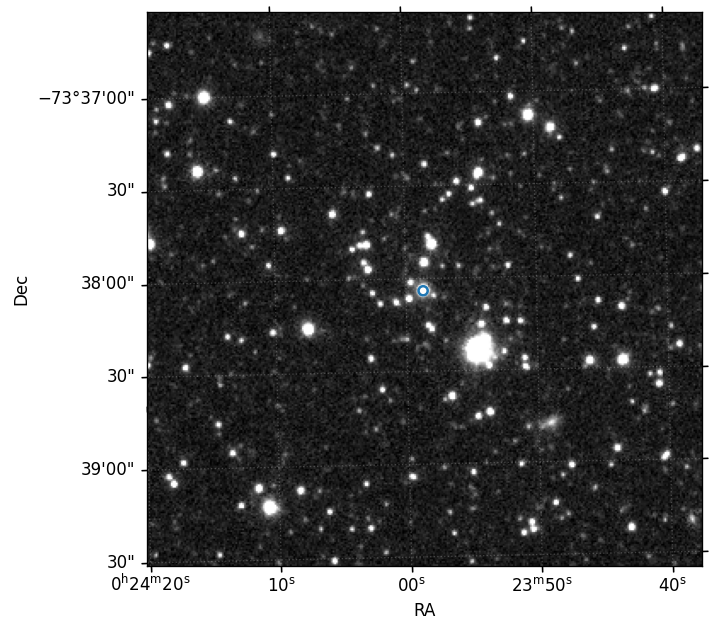

In [50]:
center_ra  = float(b3['cluster_ra_deg'].iloc[0])
center_dec = float(b3['cluster_dec_deg'].iloc[0])

plot_cluster_image_and_seds(
    b3, center_ra, center_dec,
    size_arcsec=180,
    ra_col="star_ra", dec_col="star_dec",
    id_col="star_id",
    data_release="idr6",
    image_band="r",
    limit=20,
    aperture_col="cluster_amaj",    # <-- per-star radius column
    aperture_unit="arcmin",          # values are in arcminutes
    aperture_is_diameter=True,      # set True if your column is a diameter
)